<a href="https://colab.research.google.com/github/gimoonnam/Data-Science/blob/master/MotionSignalProcessing/PostAnalysis_momentComputing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Mexican-hat-shaped-base-curves" data-toc-modified-id="Mexican-hat-shaped-base-curves-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Mexican-hat-shaped base curves</a></span></li><li><span><a href="#plot-base-set" data-toc-modified-id="plot-base-set-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>plot base set</a></span></li><li><span><a href="#Moment-Computing" data-toc-modified-id="Moment-Computing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Moment Computing</a></span></li><li><span><a href="#Data-augmentation-using-SMOTE" data-toc-modified-id="Data-augmentation-using-SMOTE-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data augmentation using SMOTE</a></span></li><li><span><a href="#Build-a-dataset" data-toc-modified-id="Build-a-dataset-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Build a dataset</a></span></li><li><span><a href="#Principal-Component-analysis" data-toc-modified-id="Principal-Component-analysis-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Principal Component analysis</a></span></li></ul></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#Classifying-speeds" data-toc-modified-id="Classifying-speeds-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Classifying speeds</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Logistic Regression Model</a></span></li><li><span><a href="#Neural-Networks" data-toc-modified-id="Neural-Networks-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Neural Networks</a></span><ul class="toc-item"><li><span><a href="#sklearn" data-toc-modified-id="sklearn-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>sklearn</a></span></li><li><span><a href="#tensorflow" data-toc-modified-id="tensorflow-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>tensorflow</a></span></li><li><span><a href="#tune-hyperpameters" data-toc-modified-id="tune-hyperpameters-2.1.2.3"><span class="toc-item-num">2.1.2.3&nbsp;&nbsp;</span>tune hyperpameters</a></span></li></ul></li></ul></li><li><span><a href="#All-classes-Classification" data-toc-modified-id="All-classes-Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>All classes Classification</a></span></li></ul></li></ul></div>

## Feature Engineering 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/DT/

/content/gdrive/MyDrive/DT


In [3]:
import pickle
import dill 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns 
import os 
from collections import OrderedDict
from collections import Counter
import librosa
%matplotlib inline 

from scipy import fftpack
from scipy.fftpack import fft, ifft
from scipy import signal
from scipy.optimize import curve_fit

from sklearn.decomposition import PCA 

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
np.set_printoptions(precision=4)

In [4]:
motions = dill.load(open("motions070120.pickle", "rb"))

### Mexican-hat-shaped base curves 

fast/LR/5m, 0, : 0.21253720422122194


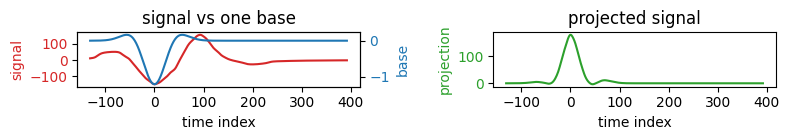

In [5]:
def base_Mexican_hat(x_range, a=40, b=5):
    A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
    return -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)


def plot_signal_with_base(base, class_name, curve_num):
    
    fig = plt.figure(figsize=(8,1.5), dpi=100, constrained_layout=False)
    axs = fig.subplots(1, 2)
    
#    fig, ax1 = plt.subplots(figsize=(4,1.5), dpi=100)

    X_ = motions.filteredMotions[class_name][curve_num]

    direction = class_name.split("/")[1]
    if direction == "LR":
        loc_peak = np.argmin(X_)
        phase = 1 
    else:
        loc_peak = np.argmax(X_)
        phase = -1
        
    x_range = np.arange(-loc_peak, loc_peak*3)
    y_signal = X_[:len(x_range)]
    y_base = phase * base(x_range)
    y_moment_computing = y_signal*y_base 
        
    color = 'tab:red'
    axs[0].set_xlabel('time index')
    axs[0].set_ylabel('signal', color=color)
    axs[0].plot(x_range, y_signal, color=color)
    axs[0].tick_params(axis='y', labelcolor=color)
    axs[0].set_title('signal vs one base')
    ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('base', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_range, y_base, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'tab:green'
    axs[1].set_xlabel('time index')
    axs[1].set_ylabel('projection', color=color)
    axs[1].plot(x_range, y_moment_computing, color=color)
    axs[1].tick_params(axis='y', labelcolor=color)
    axs[1].set_title('projected signal')
    moment_computing = np.dot(x_range, y_base)
    print("{}, {}, : {}".format(class_name, curve_num, moment_computing))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()    
    
plot_signal_with_base(base_Mexican_hat, 'fast/LR/5m', 0)

fast/RL/1m, 0, : -63.52856835109813


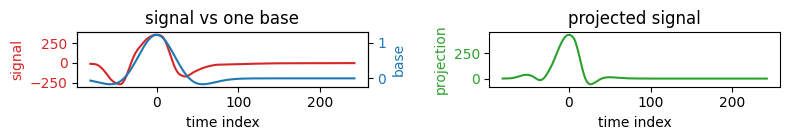

In [6]:
plot_signal_with_base(base_Mexican_hat, 'fast/RL/1m', 0)

In [7]:
classes_dict = {class_name: i for i,class_name in enumerate(motions.classes)} 
classes_dict    

{'fast/LR/1m': 0,
 'fast/LR/2m': 1,
 'fast/LR/3m': 2,
 'fast/LR/4m': 3,
 'fast/LR/5m': 4,
 'fast/LR/left': 5,
 'fast/LR/right': 6,
 'fast/RL/1m': 7,
 'fast/RL/2m': 8,
 'fast/RL/3m': 9,
 'fast/RL/4m': 10,
 'fast/RL/5m': 11,
 'fast/RL/left': 12,
 'fast/RL/right': 13,
 'slow/LR/1m': 14,
 'slow/LR/2m': 15,
 'slow/LR/3m': 16,
 'slow/LR/4m': 17,
 'slow/LR/5m': 18,
 'slow/LR/left': 19,
 'slow/LR/right': 20,
 'slow/RL/1m': 21,
 'slow/RL/2m': 22,
 'slow/RL/3m': 23,
 'slow/RL/4m': 24,
 'slow/RL/5m': 25,
 'slow/RL/left': 26,
 'slow/RL/right': 27}

In [8]:
def base_set(x_range):
    num_base = 20 
    a0 = 10
    b = 5 # fixed 
    da = 5
    y_base = np.zeros(shape=(num_base, len(x_range)))
    for i in range(num_base): 
        a = a0 + i*da 
        A = 2/np.sqrt(3*a)*np.pi**(1/4)*b
        y_base[i] = -A*(1 - x_range**2/a**2)*np.exp(-x_range**2/a**2)
        
    return y_base


def cal_momentComputing(class_name):

    num_base = 20 
    moment_computing = [] 
    signals = motions.filteredMotions[class_name]
    
    direction = class_name.split("/")[1]
    
    moment_computing =[]
    
    for i, sig in enumerate(signals):

        if direction == "LR":
            loc_peak = np.argmin(sig)
            phase = 1 
        else:
            loc_peak = np.argmax(sig)
            phase = -1
        
        #loc_peak = np.argmin(sig)
        x_range = np.arange(-loc_peak, loc_peak*3)

        if len(x_range) > 1200: 
            continue 

        y_signal = sig[:len(x_range)]
        y_bases = phase*base_set(x_range)
                
        vec_set = [] 
        for idx_vec in range(num_base):
            vec_set.append(np.dot(y_signal, y_bases[idx_vec]))
            
        vec_set.append(class_name)

        moment_computing.append(vec_set)
    
    return moment_computing


### plot base set 

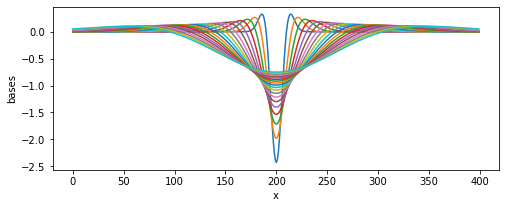

In [9]:
y_bases = base_set(np.arange(-200,200))
plt.figure(figsize=(8,3))
for y in y_bases:
    plt.plot(y)
_=plt.ylabel("bases")
_=plt.xlabel("x")

### Moment Computing 

In [10]:
dist = {} 
moment_collection = [] 
for class_name in motions.classes:     
    moment = cal_momentComputing(class_name)
    for m in moment: 
        moment_collection.append(m)
#    print(class_name, motions.filteredMotions[class_name].shape[0])
    dist[class_name] = motions.filteredMotions[class_name].shape[0]


### Build a dataset 

In [11]:
df = pd.DataFrame(np.array(moment_collection))
df.columns=['base'+str(i+1) for i in range(20)] + ['class_name']
display(df.head())
display(df.tail())

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,base11,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,10563.790067539234,13653.800646394608,16373.345212055385,18420.520510184924,19617.0479452814,19994.98015804572,19706.814659610754,18938.12959485428,17861.57773095357,16617.58141378464,15309.870283774004,14009.03051697092,12759.351935163084,11586.011882315885,10501.1761461974,9508.619094515681,8606.97814721386,7791.935407211871,7057.6274330441875,6397.528716941252,fast/LR/1m
1,14626.511350111625,18298.53243407749,21288.442088559008,23439.752924114306,24547.690075483966,24630.82050869769,23898.017215026324,22614.586066852553,21017.74786965709,19287.23449768112,17545.329738832694,15867.93444837647,14297.431116120928,12853.703293842073,11542.41109577409,10360.750941869377,9301.261159854359,8354.234433646703,7509.188093691227,6755.720148668155,fast/LR/1m
2,13416.759507009381,17209.525601739388,20526.12544633869,23048.46467217312,24579.887534910078,25131.156608557463,24857.010168619694,23967.455109602444,22668.738248401645,21134.46217924362,19496.67274824278,17848.064829375187,16248.994597531935,14735.493641931582,13326.437448969911,12029.237374480133,10844.041497654262,9766.67616897843,8790.617719475533,7908.260380934734,fast/LR/1m
3,17343.08650312764,21930.8410829216,25748.685890535995,28627.5488532989,30344.271836734402,30861.109714755497,30349.025878844317,29080.198912045948,27330.15022895007,25327.348528183975,23239.367786378276,21178.10587226048,19211.80951553818,17377.522601294757,15691.436397812597,14156.606517208802,12768.325887218247,11517.680972786507,10393.805284268672,9385.246384640257,fast/LR/1m
4,18633.83032061867,23818.492897621116,28228.849444383955,31621.875465128745,33790.20911185969,34691.73433263716,34473.24636736879,33392.02976327356,31725.70061313702,29717.087189105267,27553.544170543293,25367.032443226824,23243.33000683535,21233.43958790527,19363.93701447413,17645.17135563427,16077.274023179427,14654.333037190147,13367.172791110439,12205.13518492921,fast/LR/1m


,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,base11,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
4445,9987.771059467892,12743.498590264902,15254.384477811655,17321.76355983253,18775.209747827023,19575.318144936853,19785.72825275699,19521.28750100153,18905.4242028211,18046.099845449193,17028.487284627678,15916.835170362092,14759.071292308465,13590.980458456977,12439.179133561904,11323.110344278613,10256.455317780232,9248.240803885132,8303.77899474609,7425.4874152757875,slow/RL/right
4446,10946.55199595754,13742.394703212853,16061.759532472039,17924.183105292574,19372.995444990087,20494.532443874275,21368.268567983225,22029.462341124487,22473.655032452967,22681.99789912491,22643.689269471884,22365.942603048017,21873.287807728742,21201.681648220565,20391.815625704363,19483.812928917254,18513.881814448912,17512.681845605115,16504.90397397418,15509.585020018158,slow/RL/right
4447,11303.616446059868,14126.632082436174,16708.544052666533,19108.108580596116,21214.23705457623,22915.345263202762,24145.58064123224,24882.300079049695,25142.81166393702,24977.392437682905,24457.434648759627,23662.578142011647,22670.262586911977,21549.097097334892,20355.81587172211,19134.830475247574,17919.302301448977,16732.893960371424,15591.661502612382,14505.800039002035,slow/RL/right
4448,11843.834202487427,14764.615700045046,17241.01218135946,19394.422180363945,21259.61791977365,22801.29099951387,23972.39732418646,24740.478876549932,25099.563014765605,25074.419479331387,24715.756565700824,24089.306544830644,23264.31240645762,22305.05533701224,21266.266903482687,20191.65256062948,19114.343284196013,18058.28787794777,17039.943320578168,16069.912916612106,slow/RL/right
4449,19394.32736996328,24445.243589602338,28958.75044267886,32878.211553729525,36079.0274440481,38465.718161598066,40025.808904631005,40821.72971136536,40958.6104290294,40556.88283755481,39734.67087112553,38598.317245066784,37238.57114373882,35730.13705118599,34132.88799866466,32493.72589789168,30848.57373112656,29224.271772662913,27640.28820358144,26110.21398469828,slow/RL/right


### Data augmentation using SMOTE

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE 

y_org = df['class_name'].values
x_org = df.iloc[:,:20].values 

sm = SMOTE(random_state=42)
X_augmented, y_augmented = sm.fit_resample(x_org, y_org)

### Principal Component analysis

In [13]:
subClass = [] 

for class_name in motions.classes: 
    s = os.path.join(*class_name.split("/")[1:]) 
    if s not in subClass: 
        subClass.append(s)
    
print(subClass)

['LR/1m', 'LR/2m', 'LR/3m', 'LR/4m', 'LR/5m', 'LR/left', 'LR/right', 'RL/1m', 'RL/2m', 'RL/3m', 'RL/4m', 'RL/5m', 'RL/left', 'RL/right']


In [14]:
pairClass = [] 
for s in subClass: 
    pairClass.append(['fast/'+s, 'slow/'+ s])
    
for p in pairClass:
    print(p)

['fast/LR/1m', 'slow/LR/1m']
['fast/LR/2m', 'slow/LR/2m']
['fast/LR/3m', 'slow/LR/3m']
['fast/LR/4m', 'slow/LR/4m']
['fast/LR/5m', 'slow/LR/5m']
['fast/LR/left', 'slow/LR/left']
['fast/LR/right', 'slow/LR/right']
['fast/RL/1m', 'slow/RL/1m']
['fast/RL/2m', 'slow/RL/2m']
['fast/RL/3m', 'slow/RL/3m']
['fast/RL/4m', 'slow/RL/4m']
['fast/RL/5m', 'slow/RL/5m']
['fast/RL/left', 'slow/RL/left']
['fast/RL/right', 'slow/RL/right']


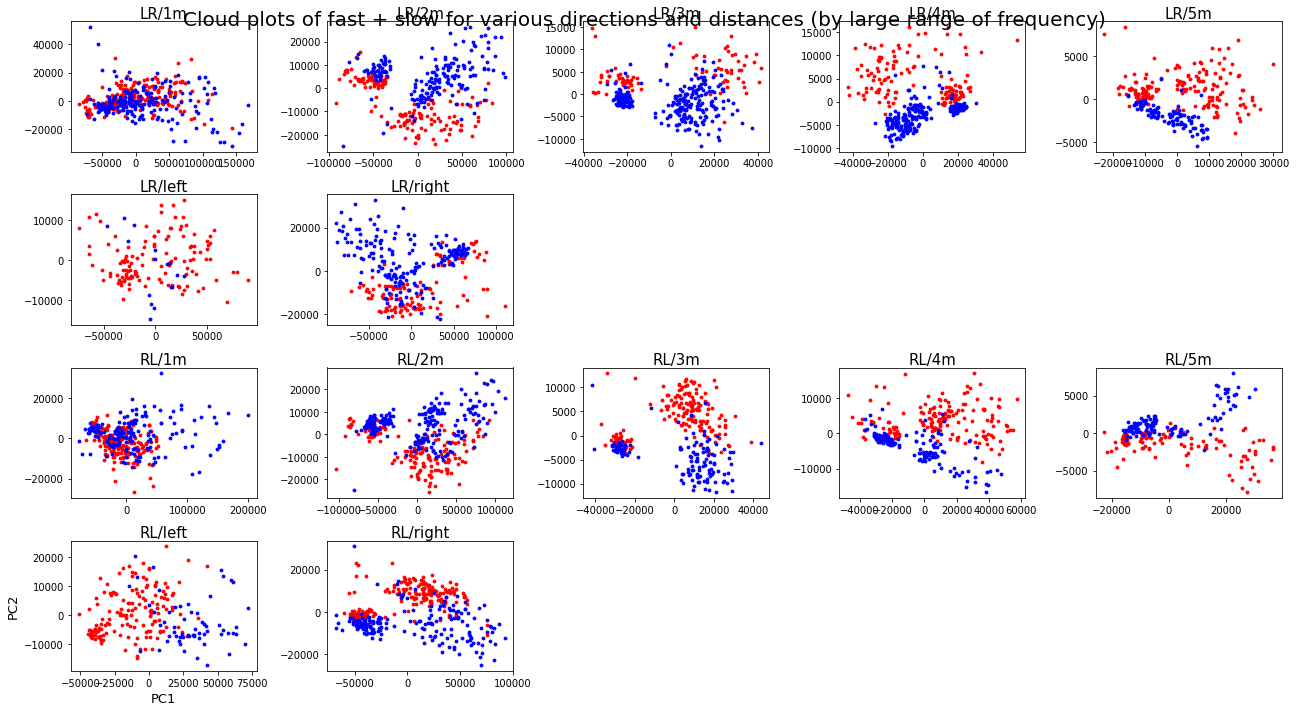

In [15]:
def PCA_for_speeds(class_pair):
    class1, class2 = class_pair
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    target = df_fs.pop('class_name') 
    target.reset_index(drop=True,inplace=True) 
    X = df_fs
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, target], axis = 1)
    
    return finalDf
    

def ListPlotClouds(): 
    
    fig = plt.figure(figsize=(18, 10), constrained_layout=False)
    n_row, n_col = 4, 5
    axs = fig.subplots(n_row, n_col)
    plt.suptitle("Cloud plots of fast + slow for various directions and distances (by large range of frequency)", 
                 fontsize=20)
    
    idx_pair = 0 
    for r in range(n_row):         
        for c in range(n_col):
            if r%2==1 and c > 1: 
                axs[r, c].axis('off')
            else: 
                axs[r, c].set_title(str(subClass[idx_pair]), 
                                    y=1.0, pad=-14, 
                                    c='k', 
                                    fontsize=15)
                df_pc = PCA_for_speeds(pairClass[idx_pair])
                class1,class2 = pairClass[idx_pair]
                df_cl1 = df_pc[df_pc['class_name']==class1]
                df_cl2 = df_pc[df_pc['class_name']==class2]
                axs[r, c].scatter(df_cl1['PC1'], df_cl1['PC2'], c='red', s=8)
                axs[r, c].scatter(df_cl2['PC1'], df_cl2['PC2'], c='blue', s=8)
                
                idx_pair +=1
    
    axs[3,0].set_xlabel('PC1', fontsize=13)
    axs[3,0].set_ylabel('PC2', fontsize=13)
    
    plt.tight_layout()
    plt.savefig('cloudPlotFordifferentSpeeds_largerRange.pdf')  

ListPlotClouds()

## Predictive models

### Classifying speeds 
#### Logistic Regression Model 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [17]:
def logisticRegression(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    n = df_fs.shape[0]
    train_df = df_fs[0:int(n*0.8)]
    test_df = df_fs[int(n*0.8):]

    train_y = train_df.pop('class_name')
    train_X = train_df  

    test_y = test_df.pop('class_name')
    test_X = test_df  

    clf = LogisticRegression(random_state=0).fit(train_X, train_y)

    return clf.score(test_X, test_y)

print(logisticRegression('fast/LR/1m', 'slow/LR/1m'))
print(logisticRegression('fast/LR/3m', 'slow/LR/3m'))
print(logisticRegression('fast/LR/5m', 'slow/LR/5m'))

0.7790697674418605
0.8857142857142857
0.8363636363636363


In [18]:
print(logisticRegression('fast/RL/1m', 'slow/RL/1m'))
print(logisticRegression('fast/RL/3m', 'slow/RL/3m'))
print(logisticRegression('fast/RL/5m', 'slow/RL/5m'))

0.7605633802816901
0.9076923076923077
0.9375


In [19]:
print(logisticRegression('fast/RL/left', 'slow/RL/left'))
print(logisticRegression('fast/RL/right', 'slow/RL/right'))

0.9069767441860465
0.9125


In [20]:
print(logisticRegression('fast/LR/left', 'slow/LR/left'))
print(logisticRegression('fast/LR/right', 'slow/LR/right'))

0.8571428571428571
0.8548387096774194


#### Neural Networks 

In [21]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing


In [22]:
def get_speeds_data(class1, class2):
    df_fs = pd.concat([df[df['class_name']==class1], 
                       df[df['class_name']==class2]])
    df_fs = shuffle(df_fs)
    df_fs.reset_index(drop=True,inplace=True)
    
    return df_fs

In [23]:
df_fs = get_speeds_data('fast/LR/1m', 'slow/LR/1m')
display(df_fs)

,base1,base2,base3,base4,base5,base6,base7,base8,base9,base10,base11,base12,base13,base14,base15,base16,base17,base18,base19,base20,class_name
0,16147.075692605282,20169.05128444635,23538.320576008493,25936.24118348684,27187.040980383117,27441.278486361087,27002.767034640878,26155.604428771094,25104.930787710553,23981.193360529112,22860.885420009843,21785.567210798454,20775.454184603863,19838.27885179883,18974.819519474946,18182.23448920907,17455.99716682966,16790.965930639424,16181.939817927003,15623.923794646322,fast/LR/1m
1,17073.015493687177,21627.78096558495,25203.005361754906,27582.086377563755,28601.872973572164,28342.42781259611,27094.145817519355,25211.347777442978,23003.598284881038,20696.31698452946,18434.332378538085,16300.943440524114,14337.78260756949,12560.34322225952,10968.656150460618,9554.145388327388,8303.861271814261,7203.02620606115,6236.525652218956,5389.748503226409,slow/LR/1m
2,9061.726039734393,11823.474685792102,14156.524970745195,15655.472141989314,16231.739631152097,16043.7606534648,15333.942228454858,14327.115929337166,13191.856969491408,12038.486176635573,10931.484608836732,9903.926721217867,8969.207896609088,8129.253370188624,7379.805407704886,6713.642774347538,6122.451240476519,5597.856468018869,5131.9549269706695,4717.553280983533,fast/LR/1m
3,31822.784160766172,40465.695638124744,48297.125266973875,54891.94754134235,59866.41413587913,63075.371397115865,64589.20426453527,64619.43807273762,63448.516181695355,61374.71981139178,58674.55794886106,55582.42428138155,52284.11213232098,48919.15969118548,45587.49992753557,42357.345880372784,39272.64302467678,36359.38940074531,33630.67216119357,31090.52725738925,slow/LR/1m
4,4860.402360619591,6166.440241836916,7246.451432806456,8009.682371124806,8396.976614113606,8420.029100442996,8147.380546339694,7671.191305633164,7078.334375165211,6436.355952410275,5791.451486481646,5172.084854843515,4593.905499099217,4064.0611634450615,3584.411020429199,3153.722260912934,2769.091740054573,2426.828462363696,2122.980567375165,1853.6364909413262,slow/LR/1m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,13365.72422961958,16190.747111633686,18123.292494796526,19195.074645850327,19192.207253953202,18138.913533197338,16315.788155650742,14063.693543517707,11662.503068032058,9300.718815047656,7087.834418478649,5077.353591246904,3287.319124136566,1715.1377435396103,347.2423126978827,-834.9844145361304,-1851.7411149336042,-2722.8751423355866,-3466.885479143694,-4100.483539506684,slow/LR/1m
426,4126.359398791534,5223.201773144672,6144.656169006212,6789.029060471035,7111.66046120998,7177.491221831378,7084.368242466484,6909.704842431272,6701.444057545552,6485.7058129159595,6275.4839595272,6076.591322711394,5891.113899407035,5719.282384096323,5560.454358531395,5413.621384102226,5277.666707515851,5151.492308126302,5034.077336531848,4924.500637154371,fast/LR/1m
427,4813.663036170952,6057.6072890335445,7077.393945284287,7875.612520733117,8396.10282284073,8605.635666280874,8529.036177235806,8228.428872014376,7774.876958705182,7231.3555025363075,6646.555997520597,6054.859786833095,5478.833224416956,4932.230197084017,4422.628663061237,3953.4544001227005,3525.428110535869,3137.5626496174564,2787.8387869911953,2473.6600448489544,slow/LR/1m
428,6849.755065250774,8701.697487700572,10245.740482550265,11395.321678043449,12046.874809311888,12178.930639752809,11860.916730722112,11211.394294626822,10354.078647763685,9392.49492321752,8402.299494041159,7433.479823525562,6516.08289916552,5666.104012336869,4890.269985858827,4189.510769363042,3561.318962842937,3001.286548784935,2504.0758830468526,2064.0183547578085,slow/LR/1m


In [24]:
y = df_fs.pop('class_name')
X = df_fs.values

In [25]:
X.shape, y.shape

((430, 20), (430,))

In [26]:
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

##### sklearn

In [27]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=20, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
def skln_binaryClassification(class1, class2):
    
    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    encoded_y = LabelEncoder().fit_transform(y)
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    results = cross_val_score(pipeline, X, encoded_y, cv=kfold)
    
    print("{} vs {}".format(class1, class2))
    print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [29]:
skln_binaryClassification('fast/LR/1m', 'slow/LR/1m')
skln_binaryClassification('fast/LR/5m', 'slow/LR/5m')
skln_binaryClassification('fast/LR/1m', 'fast/RL/1m')
skln_binaryClassification('fast/LR/5m', 'fast/RL/5m')

KeyboardInterrupt: ignored

##### tensorflow

In [30]:
def plot_loss(history, epochs): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.title('Training and Validation Loss')
    plt.show()


In [31]:
from sklearn.model_selection import train_test_split

# from keras import backend
# print(backend.tensorflow_backend._get_available_gpus())

In [32]:
def get_optimizer():
      return tf.keras.optimizers.Adam(learning_rate=0.01)


In [33]:
def nn_binaryClassification(class1, class2):

    X = np.vstack((X_augmented[y_augmented == class1, :], 
                   X_augmented[y_augmented == class2, :]))
    y = np.hstack((y_augmented[y_augmented == class1], 
                   y_augmented[y_augmented == class2]))
    
    print(X.shape, y.shape)
    
    # standardizing input features 
    scaled_X = StandardScaler().fit_transform(X)
    # ordinal encoding target value 
    encoded_y = LabelEncoder().fit_transform(y)
    
    # split into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, encoded_y, test_size=0.3, random_state=0)

    
    model = keras.Sequential([
        keras.layers.Dense(8, input_shape=(X.shape[1],),
                           activation=tf.nn.elu),
        Dropout(0.5),
        keras.layers.Dense(1,activation=tf.nn.sigmoid),    
    ])

    model.compile(optimizer=get_optimizer(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epoch = 500 
    history = model.fit(X_train, y_train, epochs=epoch,  
                        validation_split=0.2, 
                        batch_size=8,
                        verbose=0)
    
    model.evaluate(X_test, y_test)
    
    plot_loss(history, epochs=epoch)

(512, 20) (512,)
5/5 [==============================] - 0s 3ms/step - loss: 0.5006 - accuracy: 0.7403


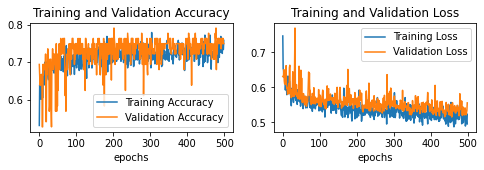

In [34]:
nn_binaryClassification('fast/LR/1m', 'slow/LR/1m')

(512, 20) (512,)
5/5 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.9610


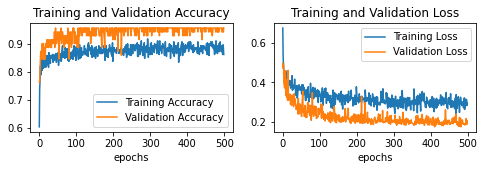

In [35]:
nn_binaryClassification('fast/LR/3m', 'slow/LR/3m')

(512, 20) (512,)
5/5 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.9805


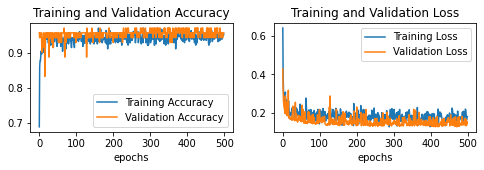

In [36]:
nn_binaryClassification('fast/LR/5m', 'slow/LR/5m')

(512, 20) (512,)
5/5 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6429


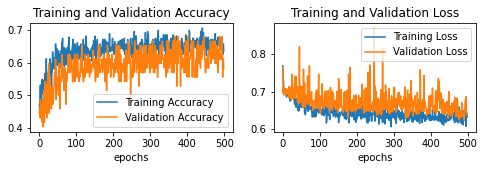

In [37]:
nn_binaryClassification('slow/RL/1m', 'slow/LR/1m')

(512, 20) (512,)
5/5 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.7792


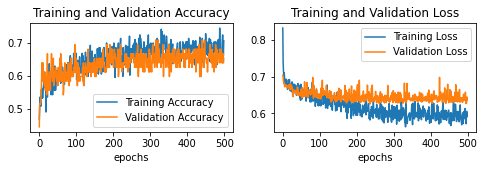

In [38]:
nn_binaryClassification('fast/RL/1m', 'fast/LR/1m')

(512, 20) (512,)
5/5 [==============================] - 0s 4ms/step - loss: 0.2182 - accuracy: 0.8961


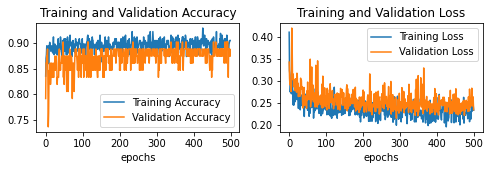

In [39]:
nn_binaryClassification('fast/LR/right', 'fast/LR/left')

(512, 20) (512,)
5/5 [==============================] - 0s 3ms/step - loss: 9.9225e-07 - accuracy: 1.0000


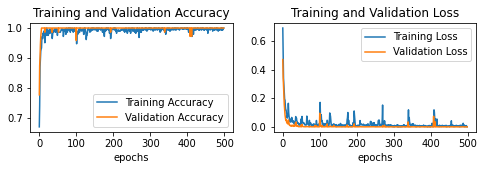

In [40]:
nn_binaryClassification('slow/LR/right', 'slow/LR/left')